polar to cartesian
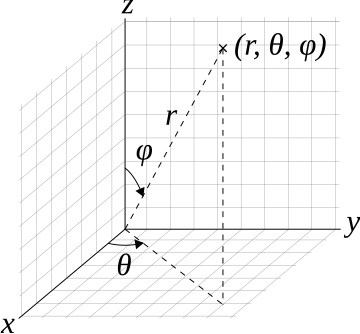

### installs

In [2]:
#check if this colab environment
on_colab = 'google.colab' in str(get_ipython())


In [3]:
import os

In [4]:
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

In [5]:
# !wget https://github.com/NVIDIAGameWorks/kaolin/raw/4d8f49dd3e617cb1fec3e2c2bc3b2903ff952321/examples/samples/rendered_clock.zip
# !unzip rendered_clock.zip
if on_colab:
  !git clone https://github.com/NVIDIAGameWorks/kaolin.git
  !pip install kaolin==0.16.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.4.0_cu121.html --quiet
  !pip install torch torchvision transformers diffusers pillow  --quiet
  !pip install objaverse --quiet
  !pip install lpips
  !pip install -U "comet_ml>=3.44.0" --quiet
  !cp /content/kaolin/kaolin/render/lighting/sg.py /usr/local/lib/python3.10/dist-packages/kaolin/render/lighting/sg.py
# !wget https://raw.githubusercontent.com/NVIDIAGameWorks/kaolin/bcbc92f4ed6f176e9d320932ea5ee1262e2ce059/examples/samples/sphere.obj

In [6]:
if on_colab:
  checkpoint_root = '/content/drive/MyDrive/Adver_diff_checkpoints/'
else:
  checkpoint_root = '/home/dcor/niskhizov/adv_diff_checkpoints/'

In [7]:
#@title comet stuff
import comet_ml
from comet_ml.integration.pytorch import watch

comet_ml.login(project_name="Adversarial-diff-rendering-notebook-V3")

In [8]:
from IPython.display import clear_output
clear_output()

### imports

In [9]:
import kaolin
import kaolin as kal
import pickle
import torch
import objaverse


import math
import matplotlib.pyplot as plt

from kaolin.render.lighting import SgLightingParameters
import numpy as np

from datetime import datetime

Warp 1.4.2 initialized:
   CUDA Toolkit 12.6, Driver 12.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 3090" (24 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/dcor/niskhizov/.cache/warp/1.4.2


###  dynamic light, camera rendering funcs

In [10]:


IMAGE_SIZE = 1024

def make_camera(eye):
  return kal.render.camera.Camera.from_args(eye=torch.tensor(eye),
                                         at=torch.tensor([0., 0., 0.]),
                                         up=torch.tensor([0., 1., 0]),
                                         fov=math.pi * 45 / 180,
                                            near=0.1, far=10000.,
                                         width=IMAGE_SIZE,
                                            height=IMAGE_SIZE,
                                            device='cuda')
forbidden_theta = []
forbidden_phi = []

resolution = 20
for theta in np.linspace(1, 0.9, 3):
    forbidden_theta.append(theta)

for phi in np.linspace(0.001, 3, resolution):
    forbidden_phi.append(phi)

forbidden_theta = set(forbidden_theta)
forbidden_phi = set(forbidden_phi)

def random_polar(r_range, phi_range, theta_range):
  done = False
  while not done:
    r = np.random.uniform(r_range[0], r_range[1])
    theta = np.random.uniform(theta_range[0], theta_range[1])
    phi = np.random.uniform(phi_range[0], phi_range[1])
    if theta not in forbidden_theta and phi not in forbidden_phi:
      done = True
  return [r, theta, phi]


def polar_to_cartesian(r, phi, theta):
  y = r * math.cos(theta)
  z = r * math.sin(theta) * math.cos(phi)
  x = r * math.sin(theta) * math.sin(phi)
  return [x,y,z]

def random_light(strength_range = [8,15],suns_range=[1, 5], phi_range=[0, math.pi * 2], theta_range=[0, math.pi / 2]):
  n_suns = int(np.random.uniform(suns_range[0],suns_range[1]))
  light_directions = []
  for i in range(n_suns):
    [r, theta, phi] = random_polar(r_range=[1, 5], phi_range=phi_range, theta_range=theta_range)
    direction = np.array(polar_to_cartesian(r, phi, theta))
    direction = direction / np.sqrt(np.sum(direction * direction))
    light_directions.append(direction)

  light_directions = torch.tensor(np.array(light_directions)).cuda()

  strength = np.random.uniform(strength_range[0],strength_range[1])
  lighting = SgLightingParameters.from_sun(light_directions.float(), strength).cuda()

  return lighting, (strength,light_directions)

def polar_camera_and_light(r, phi, theta):
  eye = polar_to_cartesian(r, phi, theta)
  camera = make_camera(eye)
  eye = np.array(eye)
  eye_norm = np.sqrt(np.sum(eye * eye))

  n_suns = int(np.random.uniform(1, 5))
  light_directions = []
  light_direction = torch.tensor(eye / eye_norm, dtype=torch.float32).view(1, 1, 3).cuda()
  strength = np.random.uniform(4, 10)
  lighting = SgLightingParameters.from_sun(light_direction.float(), strength).cuda()
  return camera, lighting

theta_eps = 0.3

def random_camera_and_light(r_range = [0, 5], phi_range=[0, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,0]):
  [r, theta, phi] = random_polar(r_range, phi_range, theta_range)
  return polar_camera_and_light(r, phi, theta), (r, phi, theta)


def render(in_cam, mesh, lighting, pbr_mat=None):
    if pbr_mat is not None:
      render_res = kal.render.easy_render.render_mesh(in_cam, mesh, lighting=lighting, custom_materials = [pbr_mat])
    else:
      render_res = kal.render.easy_render.render_mesh(in_cam, mesh, lighting=lighting)
    img = render_res[kal.render.easy_render.RenderPass.render].squeeze(0).clamp(0, 1)
    return img

# Show simple render

### lpf noise

In [11]:
from torch import nn
import torch.nn.functional as F

def generate_low_frequency_noise_fft(noise, cutoff_ratio: float = 0.05):
    """Generates low-frequency noise using FFT-based filtering."""
    # Generate random white noise
    size = noise.shape[0]
    # Perform FFT to get frequency domain representation
    noise_fft = torch.fft.fft2(noise)

    # Shift the zero frequency component to the center
    noise_fft_shifted = torch.fft.fftshift(noise_fft)

    # Create a low-pass filter (circle mask in frequency domain)
    mask = torch.zeros_like(noise_fft_shifted)
    center = size // 2
    cutoff = int(center * cutoff_ratio)  # Controls how much low frequency is kept

    for i in range(size):
        for j in range(size):
            if (i - center) ** 2 + (j - center) ** 2 < cutoff ** 2:
                mask[i, j] = 1

    # Apply the mask to the FFT coefficients
    low_freq_fft = noise_fft_shifted * mask

    # Inverse FFT to convert back to spatial domain
    low_freq_fft_shifted_back = torch.fft.ifftshift(low_freq_fft)
    low_freq_noise = torch.fft.ifft2(low_freq_fft_shifted_back).real

    return low_freq_noise

class SmoothNoise(nn.Module):
  def __init__(self, noise_shape):
      super().__init__()
      # generate noise parameter for each of the 3 channels

      self.noise_parameter = nn.ParameterList([nn.Parameter(torch.randn(noise_shape,noise_shape)) for i in range(3)])

  def forward(self, texture_map):
      all_channels_noise =  torch.stack([generate_low_frequency_noise_fft(p) for p in self.noise_parameter])
      if texture_map.shape[-1] == 3:
        all_channels_noise = all_channels_noise.T
      output = texture_map + all_channels_noise
      return output


def gaussian_kernel(size: int, sigma: float):
    """Generates a 2D Gaussian kernel."""
    coords = torch.arange(size).float()
    coords -= (size - 1) / 2.0
    g = torch.exp(-coords.pow(2) / (2 * sigma ** 2))
    g = g / g.sum()  # Normalize
    g_2d = g.unsqueeze(0) * g.unsqueeze(1)  # Outer product to create 2D kernel
    return g_2d

# Create Gaussian kernel
kernel_size = 11  # Kernel size (odd number)
sigma = 10        # Standard deviation of the Gaussian
num_noises = 1
gaussian_filter = gaussian_kernel(kernel_size, sigma).unsqueeze(0).repeat(3,1,1).unsqueeze(1)

conv_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=kernel_size,
                       padding=kernel_size // 2, bias=False,
                       padding_mode='circular', groups=3)

# Initialize the Conv2d weights with the Gaussian kernel
with torch.no_grad():
    conv_layer.weight = nn.Parameter(gaussian_filter)

#freeze conv_layer parameters
for param in conv_layer.parameters():
  param.requires_grad = False

class GNSmoothNoise(nn.Module):
  def __init__(self, noise_shape, num_noises=num_noises, zero_init=True):
      super().__init__()
      # generate noise parameter for each of the 3 channels
      self.kernel_size = kernel_size
      self.noise_parameter = nn.Parameter(torch.randn(num_noises,3,noise_shape,noise_shape)*5)
      if zero_init:
        self.noise_parameter.data = torch.zeros_like(self.noise_parameter) - 10

      self.conv_layer = conv_layer


  def forward(self, texture_map):
      return texture_map + conv_layer(self.noise_parameter).sum(0) * 0.1#(texture_map +  torch.sigmoid(self.conv_layer(self.noise_parameter).sum(0) ))/2

### Photographic augmentations

In [12]:
#@title augmentation
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

class PrintPhotographEffect:
    def __init__(self):
        self.downscale = T.Resize((300, 300))  # Simulate low-res printing
        self.upscale = T.Resize((1024, 1024))  # Upscale back to original size
        self.add_noise = T.Lambda(self._add_noise)  # Add random noise
        self.gaussian_blur = T.GaussianBlur(kernel_size=(5,5), sigma=(1.0, 4.0))  # Blur
        self.adjust_contrast = T.Lambda(self._adjust_contrast)  # Contrast adjustment
        self.vignette = T.Lambda(self._add_vignette)  # Vignette effect
        self.jitter = T.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5)
        # self.perspective_transformer = v2.RandomPerspective(distortion_scale=0.2, p=1.0)

    def _add_noise(self, img):
        rnd_scale = torch.FloatTensor(1).uniform_(0.01, 0.2).to(img.device)
        noise = torch.randn_like(img) * rnd_scale  # Gaussian noise
        return torch.clamp(img + noise, 0, 1)

    def _adjust_contrast(self, img,factor=1.2):
        factor = factor  # Slightly increase contrast
        mean = torch.mean(img, dim=(-2, -1), keepdim=True)
        return torch.clamp((img - mean) * factor + mean, 0, 1)

    def _add_vignette(self, img):
        _, height, width = img.shape
        y, x = torch.meshgrid(
            torch.linspace(-1, 1, height, device=img.device),
            torch.linspace(-1, 1, width, device=img.device)
        )
        vignette = 1 - torch.sqrt(x**2 + y**2)
        vignette = vignette.to(img.device).unsqueeze(0)  # Add channel dimension
        return torch.clamp(img * vignette, 0, 1)

    def __call__(self, img,upscale_first=False):
        img = img.permute(2,1,0)
        img = self.downscale(img)
        if upscale_first:
          img = self.upscale(img)

        img = self.add_noise(img)

        img = self.gaussian_blur(img)

        # img = self.adjust_contrast(img)

        img = self.jitter(img)
        # img = self.vignette(img)

        # img = self.perspective_transformer(img)
        if not upscale_first:
          img = self.upscale(img)

        return img.permute(2,1,0)

effect = PrintPhotographEffect()


### resnet classfier init

In [13]:


from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torchvision


weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model = model.eval().cuda()


preprocess = weights.transforms()
#input image w x h x c

def resnet_predict(image):
  with torch.no_grad():
    prediction = resnet_predict_raw(image)
    prediction = prediction.squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    # return(f"class id - {class_id} {category_name}: {100 * score:.1f}%")
    return(f"{category_name}: {100 * score:.1f}%")



def resnet_predict_raw(image):

  image = image.permute(2, 0, 1)

  if image.shape != (3, 256, 256):
    rimage = torchvision.transforms.Resize((256, 256))(image)
  else:
    rimage = image

  # Step 3: Apply inference preprocessing transforms
  batch = preprocess(rimage).unsqueeze(0)

  # Step 4: Use the model and print the predicted category
  return model(batch)

### objaverse

In [14]:
# for x,y in zip(range(len(weights.meta["categories"])),weights.meta["categories"]):
#   print(x,y)

In [18]:
import objaverse

uids = ['f53d75bd123b40bca14d12d54286f432']

objaverse.load_objects(
    uids,
    download_processes = 1
)

orig_mesh = kal.io.gltf.import_mesh('/home/dcor/niskhizov/.objaverse/hf-objaverse-v1/glbs/000-027/f53d75bd123b40bca14d12d54286f432.glb')
orig_mesh.vertices = kal.ops.pointcloud.center_points(orig_mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)

/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/kaolin/io/gltf.py:285: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1560.)
  output = torch.frombuffer(


In [ ]:
#get homedir


FileNotFoundError: [Errno 2] No such file or directory: '~'

In [ ]:
import copy
mesh = copy.deepcopy(orig_mesh)

In [ ]:
# lighting.amplitude.dtype

In [ ]:
# lighting.from_sun

In [ ]:
(camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.5, 4])#,phi_range=[ 0.2,0.2] ,theta_range=[math.pi / 2 - theta_eps, math.pi / 2 - theta_eps])
lighting, (strength,light_directions) = random_light(strength_range=[20,30])#kal.render.easy_render.default_lighting().cuda()
print(strength,light_directions)
# lighting.amplitude = torch.ones(1,3).cuda() * 8

print(r)


# mesh.materials[0].diffuse_texture = mesh.materials[0].diffuse_texture

img = render(camera, mesh.cuda(), lighting.cuda())

plt.imshow(img.detach().cpu())


resnet_predict(torch.tensor(img).cuda())

20.911917710574855 tensor([[ 0.1810,  0.8935,  0.4111],
        [ 0.0253,  0.9994, -0.0234],
        [-0.4388,  0.2161,  0.8722],
        [-0.0749,  0.9962,  0.0441]], device='cuda:0', dtype=torch.float64)
1.9745138973184195


/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/kaolin/render/easy_render/mesh.py:282: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  im_bitangents = torch.nn.functional.normalize(torch.cross(im_tangents, im_base_normals), dim=-1)
/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_1465067/1163450222.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone(

'orange: 28.9%'

In [ ]:

batch_size = 1

# analog_clock_class = torch.tensor([409]*batch_size).cuda()
# wall_clock_class = torch.tensor([892]*batch_size).cuda()
# orig_class = torch.tensor([948]*batch_size).cuda()
orig_clases = [torch.tensor([x]*batch_size).cuda() for x in range(948,959)]



critereon = torch.nn.CrossEntropyLoss()
adv_direction = 100 #None#953# pineapple #None



if adv_direction:
  directed_class = torch.tensor([adv_direction]*batch_size).cuda()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
SN = GNSmoothNoise(1024, zero_init=False).to(device)

#### load saved weights
find the most recent file in /content/drive/MyDrive/Adver_diff_checkpoints

In [ ]:

# import glob
# import re
# import os
# import torch
# # weights_paths = glob.glob('/content/drive/MyDrive/Adver_diff_checkpoints/*_without_sds_bs_20.pt')
# # weights_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
# # print(weights_paths[-1])

# files = glob.glob('/home/dcor/niskhizov/adv_diff_checkpoints//*.pt')
# files.sort(key=os.path.getmtime)
# files

# SN.noise_parameter = torch.load(files[-1]).noise_parameter

In [ ]:
# orig_mesh.materials[0].diffuse_texture.min()

In [ ]:
# sn = SN(torch.zeros(3,1024,1024).cuda()).cpu().detach()
# print(sn[0]==sn[1])
# # plt.imshow(SN(torch.zeros(3,1024,1024).cuda()).cpu().detach()[2])
# plt.imshow(SN(torch.zeros(3,1024,1024).cuda()).cpu().detach().permute(2,1,0))
# # plt.imshow(SN.noise_parameter.data[5].cpu().permute(2,1,0))
# # plt.imshow(orig_mesh.materials[0].diffuse_texture,aspect='auto')

### sds stuff

In [ ]:


from huggingface_hub import hf_hub_download
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, CLIPVisionModel,logging,CLIPProcessor
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, EulerDiscreteScheduler, AutoPipelineForImage2Image, StableDiffusionXLPipeline

# suppress partial model loading warning
logging.set_verbosity_error()

import torch
import torch.nn as nn
import torch.nn.functional as F
from loguru import logger
from safetensors.torch import load_file

import time

class StableDiffusion(nn.Module):
    def __init__(self, device, model_name='CompVis/stable-diffusion-v1-4',concept_name=None, latent_mode=True):
        super().__init__()

        try:
            with open('./TOKEN', 'r') as f:
                self.token = f.read().replace('\n', '') # remove the last \n!
                logger.info(f'loaded hugging face access token from ./TOKEN!')
        except FileNotFoundError as e:
            self.token = True
            logger.warning(f'try to load hugging face access token from the default place, make sure you have run `huggingface-cli login`.')

        self.device = device
        self.latent_mode = latent_mode
        self.num_train_timesteps = 1000
        self.min_step = int(self.num_train_timesteps * 0.02)
        self.max_step = int(self.num_train_timesteps * 0.98)

        logger.info(f'loading stable diffusion with {model_name}...')

        # 1. Load the autoencoder model which will be used to decode the latents into image space.
        self.vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_auth_token=self.token).to(self.device)

        # 2. Load the tokenizer and text encoder to tokenize and encode the text.
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(self.device)
        self.image_encoder = None
        self.image_processor = None


        # 3. The UNet model for generating the latents.
        self.unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", use_auth_token=self.token).to(self.device)


        # print('USING LIGHTNING')
        # # Load model.

        # num_inference_steps = 2
        # base_model = "stabilityai/stable-diffusion-xl-base-1.0"
        # model_repo = "ByteDance/SDXL-Lightning"
        # model_ckpt = f"sdxl_lightning_{num_inference_steps}step_unet.safetensors"
        # self.unet = UNet2DConditionModel.from_config(base_model, subfolder="unet").to('cuda')
        # self.unet.load_state_dict(load_file(hf_hub_download(model_repo, model_ckpt)))

        # pipe = StableDiffusionXLPipeline.from_pretrained(base_model, torch_dtype=torch.float16, variant="fp16")

# Ensure sampler uses "trailing" timesteps.

        # self.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

        # del pipe

        # 4. Create a scheduler for inference
        self.scheduler = PNDMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=self.num_train_timesteps)
        self.alphas = self.scheduler.alphas_cumprod.to(self.device) # for convenience

        if concept_name is not None:
            self.load_concept(concept_name)
        logger.info(f'\t successfully loaded stable diffusion!')

    def load_concept(self, concept_name):
        repo_id_embeds = f"sd-concepts-library/{concept_name}"
        learned_embeds_path = hf_hub_download(repo_id=repo_id_embeds, filename="learned_embeds.bin")
        token_path = hf_hub_download(repo_id=repo_id_embeds, filename="token_identifier.txt")
        with open(token_path, 'r') as file:
            placeholder_token_string = file.read()

        loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")

        # separate token and the embeds
        trained_token = list(loaded_learned_embeds.keys())[0]
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = self.text_encoder.get_input_embeddings().weight.dtype
        embeds.to(dtype)

        # add the token in tokenizer
        token = trained_token
        num_added_tokens = self.tokenizer.add_tokens(token)
        if num_added_tokens == 0:
            raise ValueError(
                f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")

        # resize the token embeddings
        self.text_encoder.resize_token_embeddings(len(self.tokenizer))

        # get the id for the token and assign the embeds
        token_id = self.tokenizer.convert_tokens_to_ids(token)
        self.text_encoder.get_input_embeddings().weight.data[token_id] = embeds

    def get_text_embeds(self, prompt):
        # Tokenize text and get embeddings
        text_input = self.tokenizer(prompt, padding='max_length', max_length=self.tokenizer.model_max_length, truncation=True, return_tensors='pt')

        with torch.no_grad():
            text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # Do the same for unconditional embeddings
        uncond_input = self.tokenizer([''] * len(prompt), padding='max_length', max_length=self.tokenizer.model_max_length, return_tensors='pt')

        with torch.no_grad():
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

        # Cat for final embeddings
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        return text_embeddings


    def train_step(self, text_embeddings, inputs, guidance_scale=100):

        # interp to 512x512 to be fed into vae.

        # _t = time.time()
        if not self.latent_mode:
        # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
            pred_rgb_512 = F.interpolate(inputs, (512, 512), mode='bilinear', align_corners=False)
            latents = self.encode_imgs(pred_rgb_512)
        else:
            latents = inputs
        # torch.cuda.synchronize(); print(f'[TIME] guiding: interp {time.time() - _t:.4f}s')

        # timestep ~ U(0.02, 0.98) to avoid very high/low noise level
        t = torch.randint(self.min_step, self.max_step + 1, [1], dtype=torch.long, device=self.device)

        # encode image into latents with vae, requires grad!
        # _t = time.time()

        # torch.cuda.synchronize(); print(f'[TIME] guiding: vae enc {time.time() - _t:.4f}s')

        # predict the noise residual with unet, NO grad!
        # _t = time.time()
        with torch.no_grad():
            # add noise
            noise = torch.randn_like(latents)
            latents_noisy = self.scheduler.add_noise(latents, noise, t)
            # pred noise
            latent_model_input = torch.cat([latents_noisy] * 2)
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # torch.cuda.synchronize(); print(f'[TIME] guiding: unet {time.time() - _t:.4f}s')

        # perform guidance (high scale from paper!)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # w(t), alpha_t * sigma_t^2
        # w = (1 - self.alphas[t])
        w = self.alphas[t] ** 0.5 * (1 - self.alphas[t])
        grad = w * (noise_pred - noise)

        # clip grad for stable training?
        # grad = grad.clamp(-1, 1)

        # manually backward, since we omitted an item in grad and cannot simply autodiff.
        # _t = time.time()
        latents.backward(gradient=grad, retain_graph=True)
        # torch.cuda.synchronize(); print(f'[TIME] guiding: backward {time.time() - _t:.4f}s')

        return grad # dummy loss value

    def produce_latents(self, text_embeddings, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):

        if latents is None:
            latents = torch.randn((text_embeddings.shape[0] // 2, self.unet.in_channels, height // 8, width // 8), device=self.device)

        self.scheduler.set_timesteps(num_inference_steps)

        with torch.autocast('cuda'):
            for i, t in enumerate(self.scheduler.timesteps):
                # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
                latent_model_input = torch.cat([latents] * 2)

                # predict the noise residual
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

                # perform guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents)['prev_sample']

        return latents

    def decode_latents(self, latents):
        # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
        latents = 1 / 0.18215 * latents

        with torch.no_grad():
            imgs = self.vae.decode(latents).sample

        imgs = (imgs / 2 + 0.5).clamp(0, 1)

        return imgs

    def encode_imgs(self, imgs):
        # imgs: [B, 3, H, W]

        imgs = 2 * imgs - 1

        posterior = self.vae.encode(imgs).latent_dist
        latents = posterior.sample() * 0.18215

        return latents

    def prompt_to_img(self, prompts, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):

        if isinstance(prompts, str):
            prompts = [prompts]

        # Prompts -> text embeds
        text_embeds = self.get_text_embeds(prompts) # [2, 77, 768]

        # Text embeds -> img latents
        latents = self.produce_latents(text_embeds, height=height, width=width, latents=latents, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale) # [1, 4, 64, 64]

        # Img latents -> imgs
        imgs = self.decode_latents(latents) # [1, 3, 512, 512]

        # Img to Numpy
        imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
        imgs = (imgs * 255).round().astype('uint8')

        return imgs

In [ ]:
import torch.nn.functional as F


In [ ]:
sd = StableDiffusion('cuda',latent_mode=False)

text_embed = sd.get_text_embeds(['high resolution image of a black swan'])

2024-11-25 14:26:24.292 | WARNING  | __main__:__init__:29 - try to load hugging face access token from the default place, make sure you have run `huggingface-cli login`.
2024-11-25 14:26:24.292 | INFO     | __main__:__init__:37 - loading stable diffusion with CompVis/stable-diffusion-v1-4...
2024-11-25 14:26:27.186 | INFO     | __main__:__init__:77 - 	 successfully loaded stable diffusion!


### training

In [ ]:
texture_noise_optim = torch.optim.Adam(params=list(p for p in SN.parameters() if p.requires_grad), lr=0.01)
#add lr reduce scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(texture_noise_optim, mode='min', factor=0.1, patience=10, verbose=True)

In [ ]:
# import lpips
# # loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
# loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

In [ ]:
#freeze all parameters of resnet model
model = model.to(device)
for param in model.parameters():
  param.requires_grad = False

mesh = mesh.to(device)
orig_mesh = orig_mesh.to(device)

In [ ]:
plt.imshow(effect(img).cpu())

In [ ]:
import tqdm

In [ ]:
start_time = str(datetime.now()).split('.')[0]

USE_LPIPS = False
lpips_lambda = 100
adv_lambda = 300

effective_batch_size = 1

sds_steps = 1
augment_prob = 0.9
sds_grad = 0
sds_grad_norm = 0

print(f'exeriment time {start_time}')
experiment = comet_ml.Experiment(display_summary_level=0)


exp_name = f'{sds_steps}_sds_bs_{effective_batch_size}_sds_only_blsw_photo_augmentations'


experiment.set_name(exp_name+'_'+start_time)
experiment.log_code()
# experiment.end()

# experiment = comet_ml.Experiment(display_summary_level=0)
# experiment.set_name(exp_name+'_'+start_time)
#log kernel_size and sigma as hyper param to comet

import os

watch(SN)


experiment.log_parameters({"kernel_size": kernel_size, "sigma": sigma,
                           "num_noises": num_noises, "effective_batch_size":effective_batch_size, "sds_steps": sds_steps, "augment_prob":augment_prob})


experiment.log_parameters({"lpips_lambda": lpips_lambda})


try:
  for idx in tqdm.tqdm_notebook(range(350000)):
          (camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.8, 2.5], phi_range=[0.01, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,0.01])
          lighting, _ = random_light(strength_range=[16,30],suns_range=[3,7])
          lighting = lighting.cuda()
          gt_image = render(camera, orig_mesh.cuda(), lighting)
          
          prediction_aug = None

          ### Render
          #is it the same as comparing the textures directly ?



          for i in range(sds_steps):

            texture_noise_optim.zero_grad()

            mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T).T

            image = render(camera, mesh.cuda(), lighting)

            grad = sd.train_step(text_embed, image.permute(2,0,1).unsqueeze(0))

            sds_grad_norm = grad.norm()

            # sds_grad += grad / sds_steps
            if sds_grad_norm != sds_grad_norm:
              print('sds nan')
              continue

            texture_noise_optim.step()


          texture_noise_optim.zero_grad()


          mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T).T

          image = render(camera, mesh.cuda(), lighting)

          zero_mask = image != 0
          img_loss = torch.mean(torch.abs((image - gt_image)[zero_mask]))


          augment_choise = torch.rand(1)
          if augment_choise < augment_prob:
            image_aug = effect(image)
            prediction_aug = resnet_predict_raw(image_aug)


          prediction = resnet_predict_raw(image)

          ## nan handle
          if torch.sum(prediction != prediction) != 0:
            print('nan found in prediction')
            continue

          # print(prediction.argmax(1))
          aug_pred_loss = 0
          if adv_direction:
            adv_loss =  critereon(prediction, directed_class)
            if prediction_aug is not None:
                aug_pred_loss = critereon(prediction_aug, directed_class)
                adv_loss += aug_pred_loss
          else:
            p = prediction.squeeze(0).softmax(0)
            adv_loss = torch.stack([p[c.item()] for c in orig_clases]).max()
            if prediction_aug is not None:
                p = prediction_aug.squeeze(0).softmax(0)
                aug_pred_loss = torch.stack([p[c.item()] for c in orig_clases]).max()
                adv_loss += aug_pred_loss
            # adv_loss = sum([prediction[c] for c in orig_clases]) #-1 * sum([critereon(prediction, c)  for c in orig_clases])


          ### Compute Losses ###


          if USE_LPIPS:
            lpips_loss = loss_fn_vgg(image.permute(2,1,0), gt_image.permute(2,1,0), normalize=True).mean()
          else:
            lpips_loss = 0


          if adv_loss < -65 :
            effective_adv_lambda = 0
          else:
            effective_adv_lambda = adv_lambda

          total_loss =  lpips_loss*lpips_lambda + adv_loss*effective_adv_lambda#+ img_loss * 10

          if torch.sum(total_loss != total_loss) != 0:
            raise
          ### Update the mesh ###
          total_loss.backward()
          # print(torch.stack([x.grad.sum() for x in list(SN.parameters())]))
          # vertices_optim.step()
          grad_norm =  SN.noise_parameter.grad.norm()

          if grad_norm != grad_norm:
            print('grad norm is nan')
            texture_noise_optim.zero_grad()
            continue

          texture_noise_optim.step()

          # if idx % effective_batch_size == 0:
          #       if grad_norm != grad_norm:
          #         print('grad norm is nan')
          #         texture_noise_optim.zero_grad()
          #         continue
          #       texture_noise_optim.step()
          #       texture_noise_optim.zero_grad()
                # if sds_steps > 0:
                #   sds_grad_norm = sds_grad.norm()
                # sds_grad = 0



          # texture_noise_optim.step()
          # scheduler.step(total_loss)

          # vertices_scheduler.step()
          # texture_scheduler.step()
          if idx % 100 == 0:
            plt.imshow(image.detach().cpu())
            plt.show()
            print(f"idx {idx} - img_loss: {float(img_loss)}, adv_loss {adv_loss}, grad norm {grad_norm}, lpips_loss {lpips_loss}")


          if idx % 10 == 0:
            # plt.imshow(image.detach().cpu())
            # plt.show()
            experiment.log_metrics({"img_loss": float(img_loss), "adv_loss": float(adv_loss),
                                    "lpips_loss":lpips_loss, "sds_grad_norm":sds_grad_norm, "grad_norm": grad_norm, "aug_pred_loss": aug_pred_loss}, step=idx)
            if idx % 200 == 0:
                irs = resnet_predict(torch.tensor(image.detach().cpu()).cuda())
                gtrs = resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda())
                experiment.log_text(f'(r, phi, theta) - {r}, {phi}, {theta}')
                experiment.log_text('adversarial image highest class - '+irs)
                experiment.log_text('gt image highest class - '+gtrs)
                experiment.log_image(image_data=image.detach().cpu(), name="image", step=idx)

          if idx % 2000 == 0:
            print(f"idx {idx} - img_loss: {float(img_loss)}, adv_loss {adv_loss}, grad norm {grad_norm}, lpips_loss {lpips_loss}")
            # log adv loss and img loss to experiment
            print(resnet_predict(torch.tensor(image.detach().cpu()).cuda()))
            print(resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda()))
            # save model to drive
            os.makedirs(checkpoint_root, exist_ok=True)
            torch.save(SN, checkpoint_root + '/' + str(idx) + f'_{start_time}_{exp_name}.pt')
            
except KeyboardInterrupt:
  print('terminated')
  experiment.end()
except Exception as e:
  experiment.end()
  raise e

experiment.end()

SyntaxError: invalid syntax (2993355605.py, line 192)

todo



1.   try to retrain to full the classfier with higher freq and see how it generlize
2.   try to remove the l2 or weight lambda term
3. try to use semantic distance instead L2 using VGG ETC.
4. lightning-AI lpipis loss
5.  implement batch size greater then 1
6. attack yolo
7. add discriminator loss instead of l2
8. zero shot
9. generate the noise template using nn that recieve the texture !
############################################ 10/10/24
10. add SDS (might be noisy, could require bigger batch size instead of the current 1)
11.


### playaround

In [ ]:
import torchvision

In [ ]:
torchvision.

In [ ]:
os.makedirs('/content/drive/MyDrive/Adver_diff_checkpoints/', exist_ok=True)
torch.save(SN, '/content/drive/MyDrive/Adver_diff_checkpoints/' + str(idx) + '_sds.pt')

In [ ]:
prediction = resnet_predict_raw(gt_image)
p = prediction.squeeze(0).softmax(0)
torch.stack([p[c.item()] for c in orig_clases])

In [ ]:
resnet_predict(torch.tensor(image.detach().cpu()).cuda())

In [ ]:
p = prediction.squeeze(0).softmax(0)
torch.stack([p[c.item()] for c in orig_clases])

In [ ]:
prediction[orig_clases[0].item()]

In [ ]:
orig_clases[0].cpu()

In [ ]:
SN.noise_parameter.grad.norm()  != SN.noise_parameter.grad.norm()

In [ ]:
total_loss

In [ ]:
idx

In [ ]:
image.max()

In [ ]:
SN.noise_parameter

In [ ]:
prediction.softmax(1).max()

In [ ]:
orig_clases

In [ ]:
prediction = resnet_predict_raw(image).softmax(0)
[critereon(prediction, c)  for c in orig_clases]

In [ ]:
prediction = resnet_predict_raw(image)
[critereon(prediction, c)  for c in orig_clases]

In [ ]:
a = torch.tensor([1,2,3]).float()

In [ ]:
a.requires_grad = True

In [ ]:
a.backward(gradient=torch.tensor([1,1,1]).float())

In [ ]:
(a*3).sum().backward()

In [ ]:
a.grad

In [ ]:
raise

In [ ]:
scheduler

In [ ]:
plt.imshow(image.detach().cpu())

In [ ]:
adv_loss

In [ ]:
plt.imshow(image.detach().cpu())

In [ ]:
resnet_predict(torch.tensor(image.detach().cpu()).cuda())

In [ ]:
resnet_predict(torch.tensor(gt_image.detach().cpu()).cuda())

In [ ]:
SN.noise_parameter[0].device

In [ ]:

import glob
import re
import os
import torch
weights_paths = glob.glob('/content/drive/MyDrive/Adver_diff_checkpoints/*no_sds.pt')
weights_paths.sort(key=lambda f: int(re.sub('\D', '', f)))

SN.noise_parameter = torch.load(weights_paths[-1]).noise_parameter
SN.to(device)

In [ ]:
weights_paths[-1]

### gif

In [ ]:
mesh = mesh.to(device)
orig_mesh = orig_mesh.to(device)

In [ ]:
# (camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.8, 2.5], phi_range=[3, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,1])

lighting = lighting, _ = random_light(strength_range=[15,15],suns_range=[7, 7])
# lighting.amplitude = torch.ones(1,3).cuda() * 10

mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T.to(device)).T

resolution = 20 # 100
plots = []
for theta in np.linspace(1, 0.9, 3):
  for phi in np.linspace(0.001, 3, resolution):
    camera, _ = polar_camera_and_light(1.7, phi, theta)
    # print(phi,theta)
    with torch.no_grad():
      img = render(camera.cuda(), mesh, lighting)
      orig_img = render(camera.cuda(), orig_mesh, lighting)
      img_score = resnet_predict(torch.tensor(img).cuda())
      orig_img_score = resnet_predict(torch.tensor(orig_img).cuda())
    # plot both images in the same figure
    # put the score as the images title
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(img.detach().cpu())
    axs[1].imshow(orig_img.detach().cpu())
    axs[0].set_title(img_score)
    axs[1].set_title(orig_img_score)
    plots.append([img,orig_img,img_score,orig_img_score])



In [ ]:
fig.show()

In [ ]:
import matplotlib.animation as animation

def save_plots(plots,name='image.gif'):
  #make animation out of plots list at the same figure
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  def update(frame):
    axs[0].imshow(plots[frame][0].detach().cpu())
    axs[1].imshow(plots[frame][1].detach().cpu())
    axs[0].set_title('adv image score: ' + plots[frame][2])
    axs[1].set_title('orig image score: ' + plots[frame][3])
    return axs

  ani = animation.FuncAnimation(fig, update, frames=len(plots), interval=2500, repeat=True)

  # Display the animation
  # plt.show()
  #save the animation
  gif_file = name
  ani.save(gif_file, writer='pillow', fps=3)

  print(f"Animation saved as {gif_file}")

In [ ]:
save_plots(plots,name='resnet_adv.gif')

### test on DIFFERENT model

In [ ]:
# prompt: init other image classification model and apply it on image

from torchvision.models import vgg16, VGG16_Weights
import torchvision


different_weights = VGG16_Weights.DEFAULT
different_model = vgg16(weights=weights)
different_model = different_model.eval().cuda()
different_preprocess = weights.transforms().cuda()

def different_predict(image):
  with torch.no_grad():
    # Preprocess the image (resize, normalize, etc.) as required by the VGG model
    image = image.permute(2, 0, 1)
    if image.shape != (3, 256, 256):
      rimage = torchvision.transforms.Resize((256, 256))(image)
    else:
      rimage = image

    batch = different_preprocess(rimage).unsqueeze(0)
    # Assuming you have a normalization transform
    # normalization_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # batch = normalization_transform(rimage).unsqueeze(0)
    # batch = rimage.unsqueeze(0).cuda()


    # Get the prediction
    output = different_model(batch)

    # Process the output (e.g., get the class with the highest probability)
    _, predicted_class = torch.max(output, 1)

    category_name = different_weights.meta["categories"][predicted_class]
    score = output[0][predicted_class].item()

    return(f"{category_name}: {score:.1f}%")


In [ ]:
lighting = lighting, _ = random_light(strength_range=[15,15],suns_range=[6, 6])
# lighting.amplitude = torch.ones(1,3).cuda() * 10


resolution = 20 # 100
plots = []
for theta in np.linspace(1, 0.1, 3):
  for phi in np.linspace(0.001, 3, resolution):
    camera, _ = polar_camera_and_light(1.8, phi, theta)
    # print(phi,theta)
    with torch.no_grad():
      img = render(camera.cuda(), mesh, lighting)
      orig_img = render(camera.cuda(), orig_mesh, lighting)
      img_score = different_predict(torch.tensor(img).cuda())
      orig_img_score = different_predict(torch.tensor(orig_img).cuda())
    # plot both images in the same figure
    # put the score as the images title
    # fig, axs = plt.subplots(1, 2)
    # axs[0].imshow(img.detach().cpu())
    # axs[1].imshow(orig_img.detach().cpu())
    # axs[0].set_title(img_score)
    # axs[1].set_title(orig_img_score)
    plots.append([img,orig_img,img_score,orig_img_score])



In [ ]:
save_plots(plots,name='vgg_model_adv.gif')

### check on clock projet

In [ ]:
#@title load pre-rendered clock stuff

# with open('/content/drive/MyDrive/texture_and_stuff.pkl', 'rb') as f:
#     pkl_params = pickle.load(f)
# texture, vertice_shift, nb_faces = pkl_params['texture'], pkl_params['vertice_shift'], pkl_params['nb_faces']

mesh = kal.io.usd.import_mesh('/content/drive/MyDrive/mesh.usd')

import pickle
with open('/content/drive/MyDrive/texture_and_stuff.pkl', 'rb') as f:
    texture = pickle.load(f)['texture']

pbr_mat = kal.render.materials.PBRMaterial(diffuse_texture=texture[0].detach())#torch.clamp(texture[0].detach(), 0., 1.))